In [2]:
import Pkg
Pkg.activate(@__DIR__)
# Pkg.upgrade_manifest()
# Pkg.update()
Pkg.resolve()
Pkg.instantiate()

import FiniteDiff
import ForwardDiff as FD
import Convex as cvx 
import ECOS
import MuJoCo
using LinearAlgebra
import Plots
using Random
using JLD2
using Test
using StaticArrays
using Printf
using Distributions
using MathOptInterface

  Activating project at `c:\Users\AiPEX-WS4\Documents\ocrl-piano\single_finger_free_trajectories`
  No Changes to `C:\Users\AiPEX-WS4\Documents\ocrl-piano\single_finger_free_trajectories\Project.toml`
  No Changes to `C:\Users\AiPEX-WS4\Documents\ocrl-piano\single_finger_free_trajectories\Manifest.toml`


In [3]:
Threads.nthreads()
using MuJoCo
install_visualiser()

┌ Error: curl_easy_setopt: 4
└ @ Downloads.Curl C:\Users\AiPEX-WS4\.julia\juliaup\julia-1.10.4+0.x64.w64.mingw32\share\julia\stdlib\v1.10\Downloads\src\Curl\utils.jl:50
    Updating registry at `C:\Users\AiPEX-WS4\.julia\registries\General`


LibGit2.Error.GitError: GitError(Code:ERROR, Class:SSL, Your Julia is built with a SSL/TLS engine that libgit2 doesn't know how to configure to use a file or directory of certificate authority roots, but your environment specifies one via the SSL_CERT_FILE variable. If you believe your system's root certificates are safe to use, you can `export JULIA_SSL_CA_ROOTS_PATH=""` in your environment to use those instead.)

### Load Model and Info

In [4]:
# model = load_model("../mujoco_menagerie/shadow_hand/scene_right_piano_hand.xml")
println(pwd())
model = load_model("models/scene_right_piano_hand.xml")
# model = load_model("scene_right_piano_hand.xml")
data = init_data(model)

nx = 2*model.nv
nu = model.nu

println("States: ", nx)
println("Controls: ", nu)
ϵ = 1e-6

init_visualiser()
function random_controller!(m::Model, d::Data)
    nu = m.nu
    d.ctrl .= 2*rand(nu) .- 1
    return nothing
end

println("Initial joint positions:", data.qpos)
println("Initial joint velocities:", data.qvel)

mj_resetData(model, data)

## Random Controller
# for t in 1:100
#     random_controller!(model, data)
#     step!(model, data)
# end
# println("New joint positions:", data.qpos)

# visualise!(model, data, controller=random_controller!)
print(data)

c:\Users\AiPEX-WS4\Documents\ocrl-piano\single_finger_free_trajectories
States: 54
Controls: 23
Initial joint positions:[0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0;;]
Initial joint velocities:[0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0;;]
MuJoCo Data

### Dynamics

In [30]:
function wrapped_mj_step(model, data, xk, uk)
    """
    wrapped_mj_step(model, data, xk, uk)

    Computes the next state x_{k+1} given the current state x_k and control uk
    """
    # given the current model and data. set the state and control to the model and perform a forward step
    if typeof(xk) == Vector{Float64}
    
        data.qpos .= xk[1:model.nq]
        data.qvel .= xk[(model.nq + 1):end]
        data.ctrl .= uk

    else
        # if using diff types, we need to convert the dual numbers to floats
        # uk = ForwardDiff.value.(uk)
        # xk = ForwardDiff.value.(x)
        # # set control
        # data.ctrl[:] .= converted_uk

        # # set state
        # data.qpos .= converted_x[1:model.nq]
        # data.qvel .= converted_x[(model.nq + 1):end]

        xk = ForwardDiff.value(xk)
        uk = ForwardDiff.value(uk)

        data.qpos .= xk[1:model.nq]
        data.qvel .= xk[(model.nq + 1):end]
        data.ctrl .= uk
    end
    
    # take discrete dynamics step 
    step!(model, data) 

    # return updated state k + 1
    zkp1 = zeros(model.nq + model.nv + model.na) 
    zkp1 .= get_physics_state(model, data)


    # finger_coordinates = data.geom_xpos[finger_geom_indices,:]
    
    return zkp1
end

function robohand_cost(params::NamedTuple, Z::Vector)::Real
    # TODO: implement cost function
    idx, N, xg = params.idx, params.N, params.xg
    model = params.model
    data = params.data
    Q, R, Qf = params.Q, params.R, params.Qf

    # stage cost
    cost = 0.0
    for i = 1:(N-1)
        xi = Z[idx.x[i]]
        ui = Z[idx.u[i]]

        # @show xi-xg
        # cost += 0.5*(xi[94:96]-xg[94:96])'*Q*(xi[94:96]-xg[94:96])+0.5*ui'*R*ui
        cost += 0.5*(xi-xg)'*Q*(xi-xg)+0.5*ui'*R*ui
    end

    # terminal cost 
    xf = Z[idx.x[N]]
    # cost += 0.5*(xf[94:96]-xg[94:96])'*Qf*(xf[94:96]-xg[94:96])
    cost += 0.5*(xf-xg)'*Qf*(xf-xg)

    return cost
end

function robohand_dynamics_constraints(params::NamedTuple, Z::Vector)::Vector
    idx, N, dt = params.idx, params.N, params.dt
    model = params.model
    data = params.data
    # create c in a ForwardDiff friendly way (check HW0)
    c = zeros(eltype(Z), idx.nc)
    
    for i = 1:(N-1)
        xi = Z[idx.x[i]]
        ui = Z[idx.u[i]] 
        xip1 = Z[idx.x[i+1]]
        
        # data.qpos[94:96] = xi[1:3]
        # data.qvel[94:96] = xi[4:6]

        xip1_mujoco = wrapped_mj_step(model, data, xi, ui)

        c[idx.c[i]] = xip1_mujoco - xip1
    end
    # println(typeof(c))
    return c 
end


function robohand_equality_constraints(params::NamedTuple, Z::Vector)::Vector
    # TODO: implement equality constraints
    # return zeros(eltype(Z), 0)
    N, idx, xic, xg = params.N, params.idx, params.xic, params.xg 
    model = params.model
    data = params.data

    con_1 = Z[idx.x[1]] - xic
    con_2 = Z[idx.x[N]] - xg

    # return zeros(eltype(Z), 0)
    # return [con_1; con_2]
    return [con_1; con_2; robohand_dynamics_constraints(params, Z)]


end

function robohand_inequality_constraints(params::NamedTuple, Z::Vector)::Vector
    # TODO: implement inequality constraints
    # println(Z)
    return zeros(eltype(Z), 0)
    # return inequality_constraints
end

function create_idx(nx,nu,N)
    # This function creates some useful indexing tools for Z 
    # x_i = Z[idx.x[i]]
    # u_i = Z[idx.u[i]]
    
    # our Z vector is [x0, u0, x1, u1, …, xN]
    nz = (N-1) * nu + N * nx # length of Z 
    x = [(i - 1) * (nx + nu) .+ (1 : nx) for i = 1:N]
    u = [(i - 1) * (nx + nu) .+ ((nx + 1):(nx + nu)) for i = 1:(N - 1)]
    
    # constraint indexing for the (N-1) dynamics constraints when stacked up
    c = [(i - 1) * (nx) .+ (1 : nx) for i = 1:(N - 1)]
    nc = (N - 1) * nx # (N-1)*nx 
    
    return (nx=nx,nu=nu,N=N,nz=nz,nc=nc,x= x,u = u,c = c)
end


create_idx (generic function with 1 method)

### DIRCOL

In [6]:
include(joinpath(@__DIR__, "utils","fmincon.jl"))

fmincon (generic function with 1 method)

In [20]:
@show model.nq
@show model.jnt_range
@show model.jnt_range[:,1]

@show vcat(model.jnt_range[:,1], Inf*ones(model.nv))

@show model.actuator_ctrlrange

model.nq = 27
model.jnt_range = [-0.2 0.2; -0.5 0.5; -0.2 0.2; -0.523599 0.174533; -0.698132 0.488692; -0.349066 0.349066; -0.261799 1.5708; 0.0 1.5708; 0.0 1.5708; -0.349066 0.349066; -0.261799 1.5708; 0.0 1.5708; 0.0 1.5708; -0.349066 0.349066; -0.261799 1.5708; 0.0 1.5708; 0.0 1.5708; 0.0 0.785398; -0.349066 0.349066; -0.261799 1.5708; 0.0 1.5708; 0.0 1.5708; -1.0472 1.0472; 0.0 1.22173; -0.20944 0.20944; -0.698132 0.698132; -0.261799 1.5708]
model.jnt_range[:, 1] = [-0.2, -0.5, -0.2, -0.523599, -0.698132, -0.349066, -0.261799, 0.0, 0.0, -0.349066, -0.261799, 0.0, 0.0, -0.349066, -0.261799, 0.0, 0.0, 0.0, -0.349066, -0.261799, 0.0, 0.0, -1.0472, 0.0, -0.20944, -0.698132, -0.261799]
vcat(model.jnt_range[:, 1], Inf * ones(model.nv)) = [-0.2, -0.5, -0.2, -0.523599, -0.698132, -0.349066, -0.261799, 0.0, 0.0, -0.349066, -0.261799, 0.0, 0.0, -0.349066, -0.261799, 0.0, 0.0, 0.0, -0.349066, -0.261799, 0.0, 0.0, -1.0472, 0.0, -0.20944, -0.698132, -0.261799, Inf, Inf, Inf, Inf, Inf, Inf, Inf,

23×2 transpose(::UnsafeArrays.UnsafeArray{Float64, 2}) with eltype Float64:
 -10.0       10.0
 -10.0       10.0
 -10.0       10.0
  -0.523599   0.174533
  -0.698132   0.488692
  -1.0472     1.0472
   0.0        1.22173
  -0.20944    0.20944
  -0.698132   0.698132
  -0.261799   1.5708
   ⋮         
  -0.261799   1.5708
   0.0        3.1415
  -0.349066   0.349066
  -0.261799   1.5708
   0.0        3.1415
   0.0        0.785398
  -0.349066   0.349066
  -0.261799   1.5708
   0.0        3.1415

Initial state: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Goal state: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


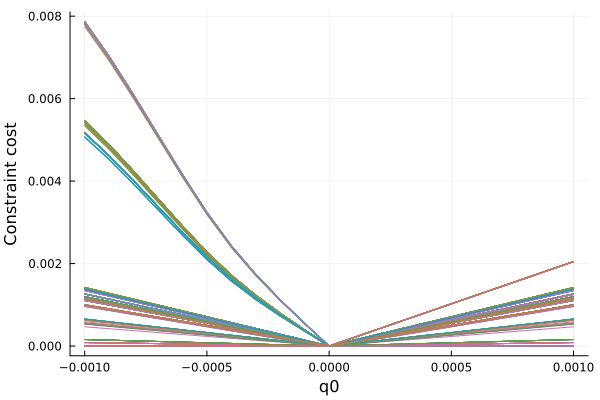

In [8]:
model = load_model("models/scene_right_piano_hand.xml")
data = init_data(model)

# reset the model and data
reset!(model, data)

nx = 2*model.nv
nu = model.nu

# initiate time and time steps
dt = model.opt.timestep
tf = 0.1
t_vec = 0:dt:tf
N = length(t_vec)

# LQR cost
Q = diagm(ones(model.nq + model.nv))
R = 100*diagm(ones(model.nu))
Qf = Q

# initial and goal states
xic = vec(vcat(copy(data.qpos), copy(data.qvel)))
println("Initial state: ", xic)

# xg = vec(vcat(copy(data.qpos), copy(data.qvel)))
xg = vec(vcat(copy(data.qpos), copy(data.qvel)))
# xg[1] = deg2rad(2)
println("Goal state: ", xg)

# indexing 
idx = create_idx(model.nq + model.nv, model.nu, N)
idx = create_idx(nx, nu, N)
params = (Q = Q, R = R, Qf = Qf, xic = xic, xg = xg, dt = dt, N = N, idx = idx, model=model, data=data)

z0 = zeros(idx.nz)
q0_array = -0.001:0.0001:0.001

# costs = zeros(length(q0_array))
# constraint_cost = zeros(length(q0_array))


costs = zeros(idx.nz, length(q0_array)) 
constraint_cost = zeros(idx.nz, length(q0_array))
using Plots

p1 = plot()
p2 = plot()
for j in 1:idx.nz
    for i in eachindex(q0_array)
        z0[j] = q0_array[i]
        # z0[idx.x[i]] .= q0_array[i]
        costs[j, i] = robohand_cost(params, z0)
        constraint_cost[j, i] = norm(robohand_dynamics_constraints(params, z0), 2)
    end
    z0 = zeros(idx.nz)

    # p1 = plot!(q0_array, costs[j, :], label="$j", xlabel="q0", ylabel="Cost", legend=false)
    # p2 = plot!(q0_array, constraint_cost[j, :], label="$j", xlabel="q0", ylabel="Constraint cost")
    p2 = plot!(q0_array, constraint_cost[j, :], xlabel="q0", ylabel="Constraint cost", legend=false)

end

# display(p1)
display(p2)

# p1 = plot(q0_array, costs, label="Cost vs q0", xlabel="q0", ylabel="Cost")
# p2 = plot(q0_array, constraint_cost, label="Constraint cost vs q0", xlabel="q0", ylabel="Constraint cost")

# println()
# println("Constraint Cost: ", constraint_cost)

# plot(p1, p2, layout=(2, 1), size=(600, 400))

In [60]:
function solve_hand_ddp(;verbose=true)
    # instantiate model and data
    model = load_model("models/scene_right_piano_hand.xml")
    data = init_data(model)

    # reset the model and data
    reset!(model, data)

    nx = 2*model.nv
    nu = model.nu

    # initiate time and time steps
    dt = model.opt.timestep
    tf = 1.0
    t_vec = 0:dt:tf
    N = length(t_vec)

    # LQR cost
    Q = diagm(ones(model.nq + model.nv))
    R = 100*diagm(ones(model.nu))
    Qf = Q

    # initial and goal states
    xic = vec(vcat(copy(data.qpos), copy(data.qvel)))
 
    println("Initial state: ", xic)

    # xg = vec(vcat(copy(data.qpos), copy(data.qvel)))
    xg = vec(vcat(copy(data.qpos), copy(data.qvel)))
    xg[2] = 0.1
    xg[5] = deg2rad(5)
    xg[21] = deg2rad(15)

    println("Goal state: ", xg)

    # indexing 
    idx = create_idx(model.nq + model.nv, model.nu, N)
    idx = create_idx(nx, nu, N)
    params = (Q = Q, R = R, Qf = Qf, xic = xic, xg = xg, dt = dt, N = N, idx = idx, model=model, data=data)


    # primal bounds
    # x_l = vcat(model.jnt_range[:,1], -Inf*ones(model.nv), model.actuator_ctrlrange[:,1]) # combine joint pos, vel, and control limits
    # x_u = vcat(model.jnt_range[:,2], Inf*ones(model.nv), model.actuator_ctrlrange[:,2])
    x_l = -Inf*ones(idx.nz)
    x_u = Inf*ones(idx.nz)

    # x_l = zeros(idx.nz)
    # x_u = zeros(idx.nz)
    # for i = 1:N
    #     # x_l[idx.x[i]] = vcat(model.jnt_range[:,1], -Inf*ones(model.nv))
    #     # x_u[idx.x[i]] = vcat(model.jnt_range[:,2], Inf*ones(model.nv))
    #     x_l[idx.x[i]] = vcat(model.jnt_range[:,1], -deg2rad(10)*ones(model.nv))
    #     x_u[idx.x[i]] = vcat(model.jnt_range[:,2], deg2rad(10)*ones(model.nv))



    #     if i < N
    #         x_l[idx.u[i]] = model.actuator_ctrlrange[:,1]
    #         x_u[idx.u[i]] = model.actuator_ctrlrange[:,2]
    #     end
    # end

    # inequality constraints
    # c_l = -1 * Inf * ones(3*(idx.N-1))
    # c_u = Inf * ones(3*(idx.N-1))
    c_l = zeros(0)
    c_u = zeros(0)

    # initial guess 
    z0 = 0.001*randn(idx.nz)
    # z0[idx.x[1]] = xic
    # z0 = zeros(idx.nz)


    # diff type
    # diff_type = :auto 
    diff_type = :finite
    
    
    Z = fmincon(robohand_cost,robohand_equality_constraints,robohand_inequality_constraints,
                x_l,x_u,c_l,c_u,z0,params, diff_type;
                tol = 1e-3, c_tol = 1e-6, max_iters = 25, verbose = verbose)
    
    # pull the X and U solutions out of Z 
    X = [Z[idx.x[i]] for i = 1:N]
    U = [Z[idx.u[i]] for i = 1:(N-1)]
    return X, U, t_vec, params
    # return
end

solve_hand_ddp (generic function with 1 method)

In [61]:
X, U, t_vec, params = solve_hand_ddp(verbose=true)


Initial state: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Goal state: [0.0, 0.1, 0.0, 0.0, 0.08726646259971647, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2617993877991494, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
---------checking dimensions of everything----------
---------all dimensions good------------------------
---------diff type set to :finite (FiniteDiff.jl)---
---------testing objective gradient-----------------
---------testing constraint Jacobian----------------
---------successfully compiled both derivatives-----
---------IPOPT beginning solve----------------------
This is Ipopt version 3.14.14

([[1.7393802418735787e-5, 0.0026183334386022574, -8.99781193915082e-7, 2.9421984971484168e-5, 3.35438908849351e-5, -7.776917263226349e-7, 2.4898787570757672e-5, 9.746292022861199e-5, -8.559667617235098e-5, -7.660173994882829e-7  …  7.199521221238126e-7, 3.3241336771621907e-7, 8.137291228122324e-7, 3.327772257635333e-6, -2.948380519387862e-6, -8.621165670293278e-10, 1.0737472245994563e-7, 1.753310159400607e-8, -4.4184409343711956e-8, -7.459178053203307e-9], [-7.635502890124458e-6, 0.005845759994622293, -4.001903416352111e-6, 0.0003029479132493383, 0.0040106709521277924, -0.00018774555741003448, 0.0008062065126772655, 0.0008182713085872393, 3.9134430470003686e-5, -0.00019823293511631563  …  -0.003912861326264232, 0.005670722316763152, -0.04948799596690476, 0.2734739942083468, 0.2772656115131613, -0.0014464600892196032, 0.01123981345078138, -0.0005509070342593664, -0.0016746675712060602, -0.00030492123850194187], [-6.0400108508565215e-5, 0.009615173636969095, -7.548116457804124e-6, 0.0006

In [59]:
# instantiate model and data
model = load_model("models/scene_right_piano_hand.xml")
data = init_data(model)

# reset the model and data
reset!(model, data)
nx = model.nq + model.nv + model.na # State vector dimension
N = length(t_vec)
states = zeros(nx, N)
ctrl_states = zeros(model.nu, N)

states[:,1] = get_physics_state(model, data)


for t in 1:N
    reset!(model, data)
    data.qpos .= X[t][1:model.nq]
    data.qvel .= X[t][model.nq+1:model.nq+model.nv]
    states[:,t] = get_physics_state(model, data)
end

visualise!(model, data, trajectories = states)

 __  __            _        _____       _ _ 
|  \/  |          | |      / ____|     (_) |
| \  / |_   _     | | ___ | |     ___   _| |
| |\/| | | | |_   | |/ _ \| |    / _ \ | | |
| |  | | |_| | |__| | (_) | |___| (_) || | |
|_|  |_|\__,_|\____/ \___/ \_____\___(_) |_|
                                      _/ |  
                                     |__/   

Press "F1" to show the help message.


### MuJoCo Integrator Test
Compare manually calling wrapped_mj_step versus the actual simulator trajectories on the different MuJoCo integrators

In [12]:
# instantiate model and data
model = load_model("models/scene_right_piano_hand.xml")
data = init_data(model)

# reset the model and data
reset!(model, data)

nx = model.nq + model.nv
nu = model.nu

# timesteps
dt = model.opt.timestep
tf = 3.0
t_vec = 0:dt:tf
N = length(t_vec)

# indexing 
idx = create_idx(model.nq + model.nv, model.nu, N)
idx = create_idx(nx, nu, N)

# xkp1 = wrapped_mj_step(model, data, z0[idx.x[1]], z0[idx.u[1]])

x_ic = vec(vcat(copy(data.qpos), copy(data.qvel)))
z = zeros(nx, N)
z[:,1] = xic

for k in 1:(N-1)
    # xk = z[idx.x[k]]
    # uk = zeros(nu)
    xk = z[:,k]
    uk = zeros(nu)
    # uk[1] = 0.2
    # uk[10] = 0.2
    # uk[15] = 0.3

    zkp1 = wrapped_mj_step(model, data, xk, uk)
    xkp1 = zkp1[1:nx]

    # z[idx.x[k+1]] = xkp1
    z[:,k+1] = xkp1
end

reset!(model, data)
visualise!(model, data, trajectories=[z])


 __  __            _        _____       _ _ 
|  \/  |          | |      / ____|     (_) |
| \  / |_   _     | | ___ | |     ___   _| |
| |\/| | | | |_   | |/ _ \| |    / _ \ | | |
| |  | | |_| | |__| | (_) | |___| (_) || | |
|_|  |_|\__,_|\____/ \___/ \_____\___(_) |_|
                                      _/ |  
                                     |__/   

Press "F1" to show the help message.


In [13]:
# 